# Regression Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Spain Electricity Shortfall Challenge

The government of Spain is considering an expansion of it's renewable energy resource infrastructure investments. As such, they require information on the trends and patterns of the countries renewable sources and fossil fuel energy generation. Your company has been awarded the contract to:

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of forecasting the three hourly demand shortfalls;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine what features were most important in the model’s prediction decision, and
- 7. explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model the shortfall between the energy generated by means of fossil fuels and various renewable sources - for the country of Spain. The daily shortfall, which will be referred to as the target variable, will be modelled as a function of various city-specific weather features such as `pressure`, `wind speed`, `humidity`, etc. As with all data science projects, the provided features are rarely adequate predictors of the target variable. As such, you are required to perform feature engineering to ensure that you will be able to accurately model Spain's three hourly shortfalls.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [ ]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import random
import string
import re
import string
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import plotly.express as px
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Libraries for data preparation and model building
#import *
nltk.download(['punkt','stopwords','wordnet'])

# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###

#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [163]:
# load the data
df = pd.read_csv('../resources/data/train.csv')
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


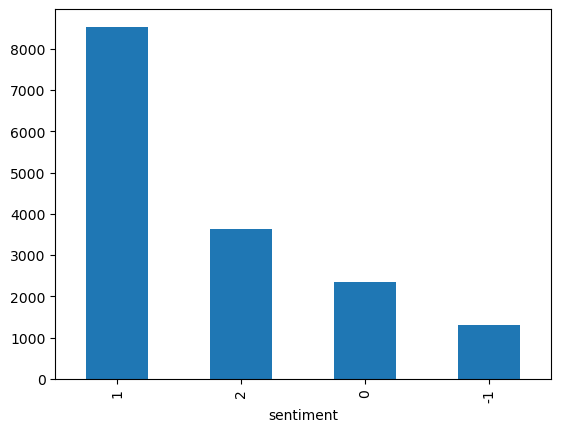

In [121]:
sentiment_values = [-1, 0, 1, 2]
df['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

In [193]:
# Function to remove punctuation
def remove_punctuation(text):
    return ''.join([l for l in text if l not in string.punctuation])

# Tokenize message
def tokenize_message(text):
    
    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords and punctuation
    return [word for word in tokens if word not in stop_words and len(word)>2]

# Preprocessing function
def preprocess_text(text):

    # Convert text to lowercase
    text = text.lower()

    # Define the patterns for detecting URLs and email addresses
    pattern_url = r'http\S+'
    pattern_email = r'\S+@\S+'

    # Replace URLs and email addresses with placeholders
    subs_url = 'url-web'
    subs_email = 'email-address'
    text = re.sub(pattern_url, subs_url, text)
    text = re.sub(pattern_email, subs_email, text)
    
    # Remove web-urls
    text = re.sub(pattern_url, subs_url, text)

    # Return preprocessed text as a string
    return remove_punctuation(text)

In [194]:

df['cleaned_message'] = df['message'].apply(preprocess_text)
df['tokenized_message'] = df['cleaned_message'].apply(tokenize_message)

In [195]:
#df['message'][0]

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


In [196]:
# look at data statistics

# Examine the structure of the dataset
num_rows, num_cols = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Check the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Identify missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values)

# Data statistics
data_stats = df.describe(include='all')
print("\nData statistics:")
print(data_stats)

# Explore the distribution of sentiment values
sentiment_distribution = df['sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_distribution)

Number of rows: 15819
Number of columns: 5

Data types of each column:
sentiment             int64
message              object
tweetid               int64
cleaned_message      object
tokenized_message    object
dtype: object

Missing values:
sentiment            0
message              0
tweetid              0
cleaned_message      0
tokenized_message    0
dtype: int64

Data statistics:
           sentiment  \
count   15819.000000   
unique           NaN   
top              NaN   
freq             NaN   
mean        0.917504   
std         0.836537   
min        -1.000000   
25%         1.000000   
50%         1.000000   
75%         1.000000   
max         2.000000   

                                                                                                                                                   message  \
count                                                                                                                                                15819   
unique 

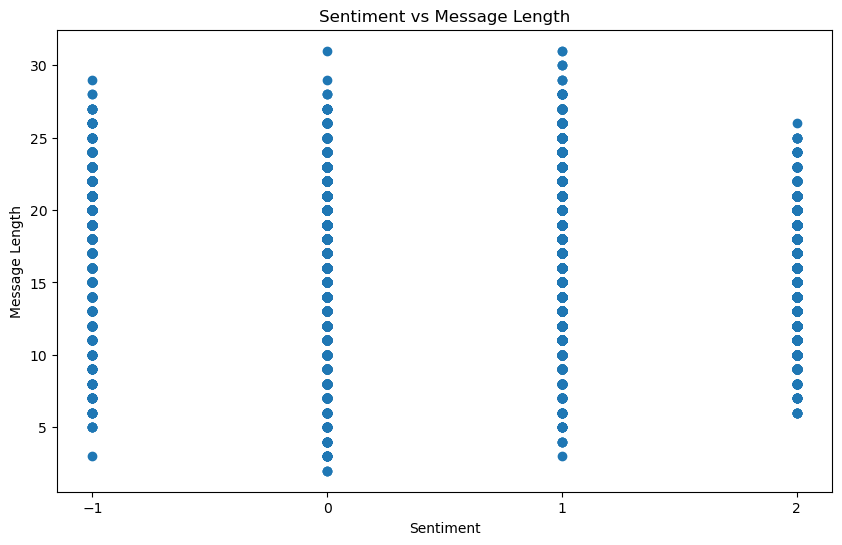

In [92]:
# plot relevant feature interactions
# Calculate message length


In [202]:
# evaluate correlation

# Calculate preprocessed message length
df['tokenized_message_length'] = df['tokenized_message'].apply(len)

# Display preprocessed messages and their lengths
df.head()


,sentiment,message,tweetid,cleaned_message,tokenized_message,tokenized_message_length
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]",15
1,1,It's not like we lack evidence of anthropogenic global warming,126103,its not like we lack evidence of anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]",6
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,rt rawstory researchers say we have three years to act on climate change before it’s too late urlweb urlweb,"[rawstory, researchers, say, three, years, act, climate, change, late, urlweb, urlweb]",11
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]",9
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,rt soynoviodetodas its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight,"[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]",11


In [207]:
import plotly.express as px

# Calculate message length in characters
# df['tokenized_message_chars'] = df['tokenized_message'].apply(lambda x: len(''.join(x)))

# # Calculate message length in words (assuming whitespace separation)
# df['message_length_words'] = df['tokenized_message'].apply(lambda x: len(x.split()))

# Distribution of message length
fig = px.histogram(df, x='tokenized_message_length', nbins=20, title='Distribution of Tokenized Message Length')
fig.update_layout(xaxis_title='Message Length (Words)', yaxis_title='Frequency')
fig.show()

# Compare message lengths across sentiments
sentiment_lengths = df.groupby('sentiment')['tokenized_message_length'].mean().reset_index()
fig = px.bar(sentiment_lengths, x='sentiment', y='tokenized_message_length', title='Comparison of Tokenized Message Lengths across Sentiments')
fig.update_layout(xaxis_title='Sentiment', yaxis_title='Average Message Length (Words)', xaxis={'tickvals': [-1, 0, 1, 2]})
fig.show()

# Filter data for the specified sentiment values
sentiment_values = [-1, 0, 1, 2]
df_filtered = df[df['sentiment'].isin(sentiment_values)]

# Plot sentiment vs message length
fig = px.scatter(df_filtered, x='sentiment', y='tokenized_message_length', title='Sentiment vs Message Length')
fig.update_layout(xaxis_title='Sentiment', yaxis_title='Message Length', xaxis={'tickvals': [-1, 0, 1, 2]})
fig.show()



In [212]:
import plotly.graph_objects as go

# Group data by sentiment and calculate outliers for each category
sentiment_groups = df.groupby('sentiment')
outliers = sentiment_groups.apply(lambda x: x[(x['tokenized_message_length'] < x['tokenized_message_length'].quantile(0.25)) | (x['tokenized_message_length'] > x['tokenized_message_length'].quantile(0.75))])

# Count outliers and calculate percentage
outlier_counts = outliers.reset_index().groupby('sentiment').size()
outlier_percentages = outlier_counts / sentiment_groups.size() * 100

# Create a boxplot for each sentiment category
fig = go.Figure()

for sentiment in sentiment_groups.groups.keys():
    sentiment_data = df[df['sentiment'] == sentiment]
    fig.add_trace(go.Box(y=sentiment_data['tokenized_message_length'], name=sentiment))

fig.update_layout(title='Boxplot of Message Length by Sentiment',
                  yaxis_title='Message Length (Characters)',
                  xaxis_title='Sentiment',
                  showlegend=True)

# Show the graph
fig.show()


ValueError: cannot insert sentiment, already exists

In [74]:
# Concatenate all messages into a single string
all_messages = ' '.join(df['message'].values)

# Tokenize the text
tokens = all_messages.split()

# Count the frequency of each word
word_freq = pd.Series(tokens).value_counts().reset_index()
word_freq.columns = ['Word', 'Frequency']

# Select the top N most common words
top_words = word_freq.head(10)

# Create bar chart using Plotly
fig = px.bar(top_words, x='Word', y='Frequency')
fig.update_layout(
    title='Top 10 Most Common Words',
    xaxis_title='Word',
    yaxis_title='Frequency',
    showlegend=False
)
fig.show()

In [139]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and non-alphabetic characters
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a single string
    preprocessed_text = " ".join(lemmatized_tokens)
    
    return preprocessed_text

df['message_tokens'] =df['message'].apply(preprocess_text) 

In [140]:
df.head()

,sentiment,message,tweetid,cleaned_message,message_length_chars,message_length_words,message_tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,140,19,polyscimajor epa chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,62,10,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say we have three year...,140,19,rt rawstory researcher say three year act clim...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 was a pivotal year in...,99,15,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas its 2016 and a racist sexis...,122,18,rt soynoviodetodas racist sexist climate chang...


In [138]:
# Create a CountVectorizer to convert text into a matrix of token counts
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['message'])

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

# Print the top words per topic
feature_names = vectorizer.get_feature_names_out()
num_words = 10
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
    print(f"Topic #{topic_idx+1}: {' '.join(top_words)}")

Topic #1: rt in she change climate about to https co doesn
Topic #2: climate https change co rt the to trump is on
Topic #3: climate change the rt of in to and is it
Topic #4: climate change https co rt to the of is in
Topic #5: global warming climate to change rt https co you the


In [76]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields preprocessed sentences from the dataframe."""

    def __init__(self, df):
        self.df = df

    def __iter__(self):
        for line in self.df['preprocessed_message']:
            # Split the preprocessed text into tokens
            tokens = utils.simple_preprocess(line)
            
            # Yield the tokens as a list of strings
            yield tokens

In [79]:
# Create an instance of MyCorpus with your dataframe
corpus = MyCorpus(df)

# Train the Word2Vec model
model = Word2Vec(corpus)

# Save the trained Word2Vec model
model_path = "../resources/models/word2vec_model"
model.save(model_path)

In [80]:

# To load a saved model:
#
new_model = gensim.models.Word2Vec.load(model_path)

In [87]:
from nltk.stem import SnowballStemmer

def apply_stemming(df, column_name):
    stemmer = SnowballStemmer(language='english')
    stemmed_column_name = f'{column_name}_stemmed'
    df[stemmed_column_name] = df[column_name].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    return df

In [ ]:
# Randomly sample the dataset
sample_size = 1000
random.seed(42)
df_sample = df.sample(n=sample_size, random_state=42)

# Initialize spaCy's English language model
nlp = spacy.load('en_core_web_sm')

# Perform NER on the sampled data
ner_results = []
for text in df_sample['message']:
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    ner_results.append(entities)

# Create a DataFrame from the NER results
df_ner = pd.DataFrame({'NER': ner_results})

# Display the NER results
print(df_ner.head())

                                                 NER
0  [(RT @AntonioParis:, ORG), (Texas, GPE), (thir...
1               [(N.Y. Times, ORG), (FOX NEWS, ORG)]
2                                   [(muslim, NORP)]
3                                                 []
4                                                 []


In [78]:
# Preprocess the text data
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and non-alphabetic characters
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a single string
    preprocessed_text = " ".join(lemmatized_tokens)
    
    return preprocessed_text

# Apply the preprocessing function to the 'message' column
df['preprocessed_message'] = df['message'].apply(lemmatize_text)

# Save the preprocessed data to a new CSV file
df.to_csv("preprocessed_data.csv", index=False)
# Preprocess your text data
preprocessed_data = df['preprocessed_message']   # Preprocessed text data

# Tokenize the preprocessed data
tokenized_data = [nltk.word_tokenize(sentence) for sentence in preprocessed_data]

# Train Word2Vec embeddings model
word2vec_model = Word2Vec(tokenized_data, vector_size=100, window=5, min_count=5, workers=4)

# Save the Word2Vec model
model_path = "../resources/models/word2vec_model"
word2vec_model.save(model_path)

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(word2vec_model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

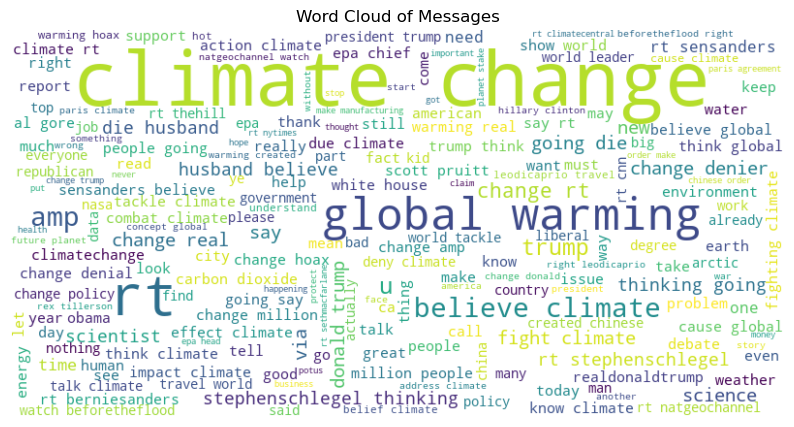

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Concatenate all the preprocessed messages into a single string
all_messages = ' '.join(df['preprocessed_message'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_messages)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Messages')
plt.show()


In [118]:
df[df['sentiment'] == category]

,sentiment,message,tweetid,cleaned_message
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say we have three year...
12,2,RT @tveitdal: We only have a 5 percent chance ...,454673,rt tveitdal we only have a 5 percent chance of...
14,2,Fossil fuel giant ExxonMobil ‘misled’ the publ...,658092,fossil fuel giant exxonmobil ‘misled’ the publ...
26,2,Bangladesh confronting climate change head on ...,365291,bangladesh confronting climate change head on ...
32,2,RT @latimes: Atmospheric rivers fueled by clim...,143471,rt latimes atmospheric rivers fueled by climat...
...,...,...,...,...
15802,2,Michael Bloomberg to world leaders: ignore Tru...,585908,michael bloomberg to world leaders ignore trum...
15803,2,"Suicides of nearly 60,000 Indian farmers linke...",296403,suicides of nearly 60000 indian farmers linked...
15805,2,RT @GrindTV: New head of EPA says climate chan...,830383,rt grindtv new head of epa says climate change...
15809,2,The quest to capture and store carbon — and sl...,705048,the quest to capture and store carbon — and sl...


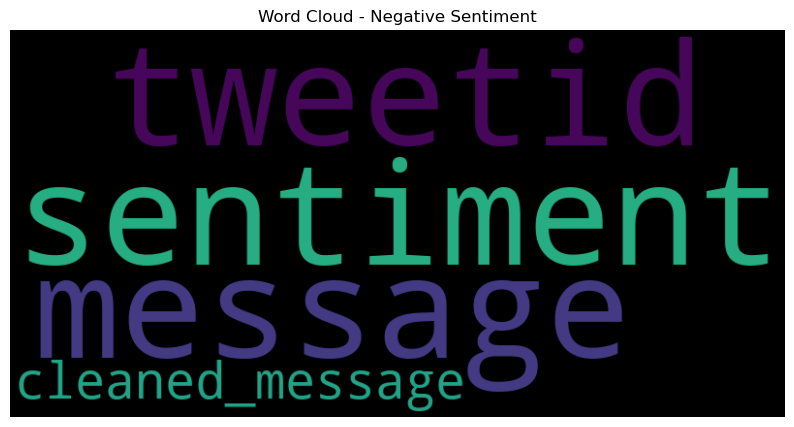

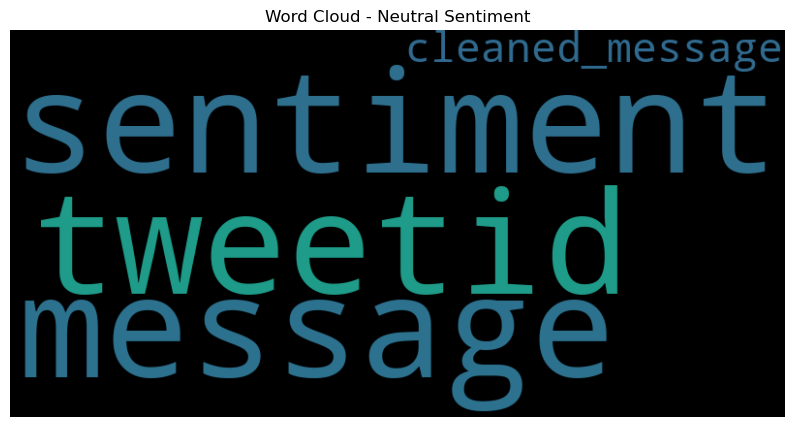

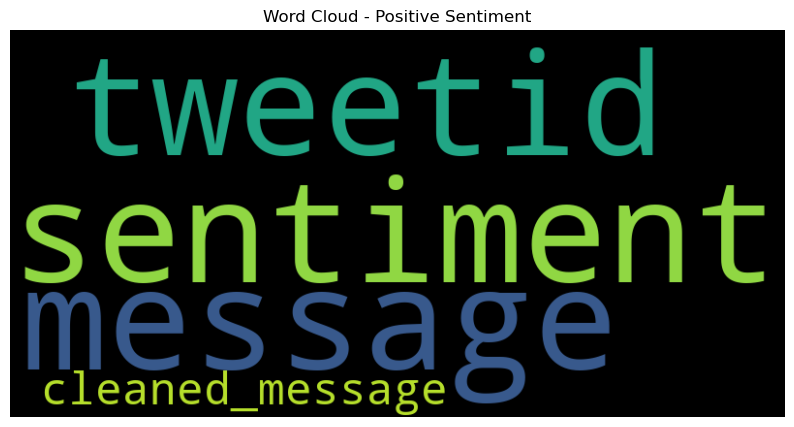

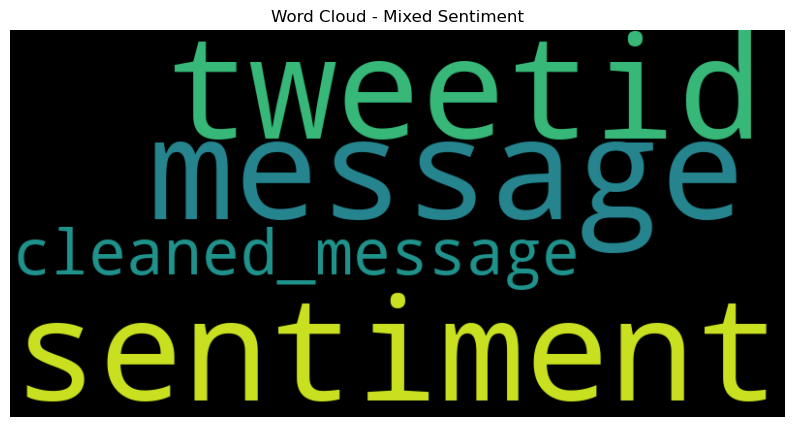

In [116]:
sentimentMap = { -1:'negative', 0:'neutral', 1:'positive',  2:'mixed' }
sentiment_categories = [-1,0,1,2]

for category in sentiment_categories:
    # Filter the data for the current sentiment category
    category_text = ' '.join(df[df['sentiment'] == category][tokenized])
    
    # Create a WordCloud object and generate the word cloud
    wordcloud = WordCloud(width=800, height=400).generate(category_text)
    
    # Display the word cloud with the corresponding category as the title
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {sentimentMap[category].capitalize()} Sentiment")
    plt.show()

In [117]:
df['sentiment'].head()

0    1
1    1
2    2
3    1
4    1
Name: sentiment, dtype: int64

In [82]:

# Map sentiment values to consecutive integers starting from 0
sentiment_mapping = {-1: 0, 0: 1, 1: 2, 2: 3}
df['mapped_sentiment'] = df['sentiment'].map(sentiment_mapping)
df.head()

,sentiment,message,tweetid,mapped_sentiment,message_length_chars,message_length_words,preprocessed_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,2,140,19,polyscimajor epa chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,2,62,10,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,3,140,19,rt rawstory researcher say three year act clim...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,2,99,15,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,2,122,18,rt soynoviodetodas racist sexist climate chang...


In [88]:
stemmed_df = apply_stemming(df, 'preprocessed_message')
stemmed_df.head()

,sentiment,message,tweetid,mapped_sentiment,message_length_chars,message_length_words,preprocessed_message,preprocessed_message_stemmed
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,2,140,19,polyscimajor epa chief think carbon dioxide ma...,polyscimajor epa chief think carbon dioxid mai...
1,1,It's not like we lack evidence of anthropogeni...,126103,2,62,10,like lack evidence anthropogenic global warming,like lack evid anthropogen global warm
2,2,RT @RawStory: Researchers say we have three ye...,698562,3,140,19,rt rawstory researcher say three year act clim...,rt rawstori research say three year act climat...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,2,99,15,todayinmaker wired pivotal year war climate ch...,todayinmak wire pivot year war climat chang http
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,2,122,18,rt soynoviodetodas racist sexist climate chang...,rt soynoviodetoda racist sexist climat chang d...


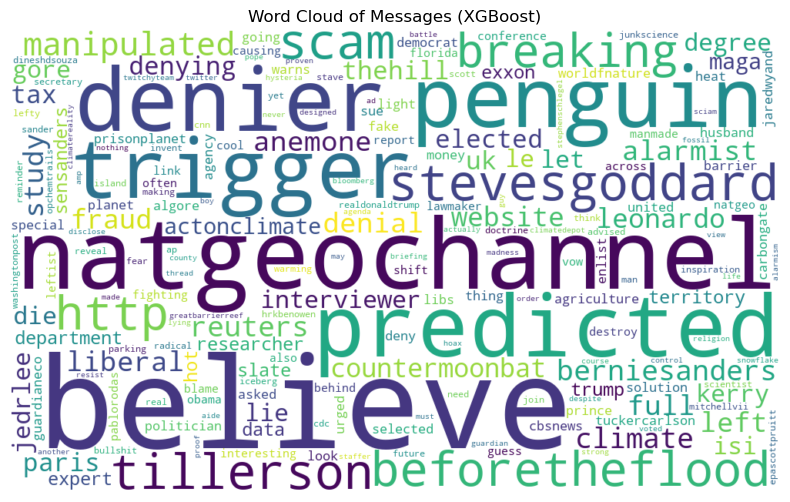

In [86]:


# Preprocess the messages and create a feature matrix using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['preprocessed_message'])

# Define the target variable
y = df['mapped_sentiment']

# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X, y)

# Get the feature importance from the XGBoost model
feature_names = vectorizer.get_feature_names_out()
feature_importances = model.feature_importances_

# Create a dictionary mapping feature names to importance scores
feature_scores = {feature_names[i]: score for i, score in enumerate(feature_importances)}

# Sort the feature scores in descending order
sorted_scores = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Generate word cloud based on the feature scores
wordcloud = WordCloud(width=1000, height=600, background_color='white')
wordcloud.generate_from_frequencies(dict(sorted_scores))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Messages (XGBoost)')
plt.show()


<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

In [ ]:
# remove missing values/ features

In [ ]:
# create new features

In [ ]:
# engineer existing features

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [ ]:
# split data

In [ ]:
# create targets and features dataset

In [ ]:
# create one or more ML models

In [ ]:
# evaluate one or more ML models

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [ ]:
# discuss chosen methods logic